# 목차
- Step 1. Set-up
- Step 2. 데이터 준비하기
- Step 3. 데이터 시각화
- Step 4. CNN 모델링
- Step 5. 데이터 imbalance 처리
- Step 6. 모델 훈련
- Step 7. 결과 확인과 시각화
- Step 8. 성능 개선 시도
- Step 9. 결론
- Step 10. 회고

## Step 1. Set-up
- 가장 먼저, 패키지들을 import 해보자

In [428]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

- 데이터 불러오기

In [429]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 15

### Step 2. 데이터 준비하기

- train, val, test로 나누어져 있는 데이터들의 개수 파악하기

In [430]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- val 데이터의 수가 너무 작기 때문에
- train + val = train : val = 80 : 20으로 분할

In [431]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4185
624
1047


- train = 4185
- test = 624
- val = 1047
<br/><br/>
- train 데이터에서 정상, 폐렴 이미지 수 파악하기
<br/><br/>
- 파일 경로를 통해 정상, 폐렴 이미지 수를 파악할 수 있다.

In [432]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 데이터를 확인해본 결과
    - 정상 이미지 보다 폐렴 이미지가 3개 가까이 더 많다.
    - 이 사실은 데이터가 클래스별로 imbalance 하다.
    - balance가 좋을수록 training을 더 잘한다.

In [433]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- train, validation 데이터셋 개수 확인

In [434]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 라벨 데이터를 만들어주는 함수

In [435]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 제각각인 이미지 데이터의 사이즈 통합 및 줄이기

In [436]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- train 데이터셋과 validation 데이터 셋 만들기
- AUTOTUNE 변수를 이용하면 더욱 빠르게 데이터를 처리

In [437]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지 리사이즈 및 라벨링이 되었는지 확인
- train_ds.take(1)은 하나의 데이터만 가져온다는 뜻

In [438]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- test 데이터셋 생성 및 갯수 확인

In [439]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- tf.data 파이프라인을 이용해서 prepare_for_training() 함수 정의
    - shuffle() : 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일
    - repeat() : epoch를 진행하면서 여러 번 데이터셋 사용
    - batch() : BATCH_SIZE에서 정한 만큼의 배치
    - PREFETCH() : 첫 번째 데이터 GPU -> 두 번째 데이터 CPU가 준비

In [440]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화

- 첫 번째 배치 추출

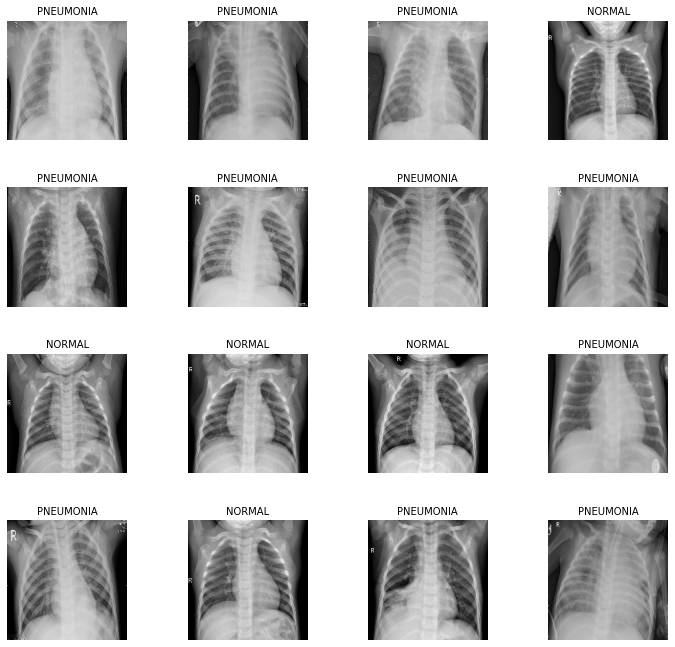

In [441]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, batch_size=16):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,math.ceil(batch_size/4),n+1)
        plt.tight_layout()
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA", fontsize=10)
        else:
            plt.title("NORMAL", fontsize=10)
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

### Step 4. CNN 모델링
1. Convolution 두 번 진행
2. Batch Normalization을 통해 gradient vanishing, exploding 해결
3. Max Pooling

In [442]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [443]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- Dense Block 생성 함수
    - Batch Normalization, Dropout : regularization 기법
        - Batch Normalization + Dropout
        - 같이 써도 된다, 안 된다.

In [444]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
- 정상 데이터와 폐렴 데이터 중 폐렴 데이터가 3배 가까이 많다. => 한 라벨이 많음 : imbalance
- 해결방법 : Weight balancing
    - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치 부여
    - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight에 이러한 클래스별 가중치를 세팅할 수 있도록 지원
<br/><br/>
- weight_for_0 : 정상 이미지에 사용할 weight
- weight_for_1 : 폐렴 이미지에 사용할 weight
- weight는 정상과 폐렴 전체 데이터 건수에 반비례하도록 설정

In [445]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련
- 라벨이 2개 : binary_crossentropy
- optimizer : adam
- 성과 측정 : accuracy, precision, recall

In [446]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [447]:
model.summary()

Model: "sequential_309"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_219 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_302 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_303 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_304 (Sequential)  (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_117 (Dropout)        (None, 11, 11, 128)    

In [448]:
# Early stopping 콜백 정의
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표 (검증 손실을 기준으로 사용)
    patience=5,  # 지정된 epoch 동안 개선이 없을 때 훈련 중단
    restore_best_weights=True  # 최상의 가중치를 복원
)

- 모델 fit하기

In [449]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        # callbacks=[early_stopping],
    )

Epoch 1/15
261/261 [==============================] - 97s 199ms/step - loss: 0.4137 - accuracy: 0.8070 - precision: 0.9535 - recall: 0.7787 - val_loss: 0.6728 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 51s 194ms/step - loss: 0.2595 - accuracy: 0.8975 - precision: 0.9711 - recall: 0.8886 - val_loss: 1.2897 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 50s 193ms/step - loss: 0.2066 - accuracy: 0.9181 - precision: 0.9779 - recall: 0.9105 - val_loss: 0.1677 - val_accuracy: 0.9337 - val_precision: 0.9943 - val_recall: 0.9148
Epoch 4/15
261/261 [==============================] - 51s 198ms/step - loss: 0.1732 - accuracy: 0.9332 - precision: 0.9813 - recall: 0.9280 - val_loss: 0.1054 - val_accuracy: 0.9567 - val_precision: 0.9864 - val_recall: 0.9541
Epoch 5/15
261/261 [==============================] - 52s 198ms/step - loss: 0.1708 - accura

### Step 7. 결과 확인과 시각화
- 그래프로 Epochs마다 모델의 precision, recall, accuracy, loss 시각화

In [450]:
def plot_metrics(history):
    plt.rcParams.update({'font.size': 20})  # 폰트 크기 조절

    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met], label='train', color='b', linestyle='-')
        ax[i].plot(history.history['val_' + met], label='val', color='r', linestyle='--')
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend()

    plt.show()


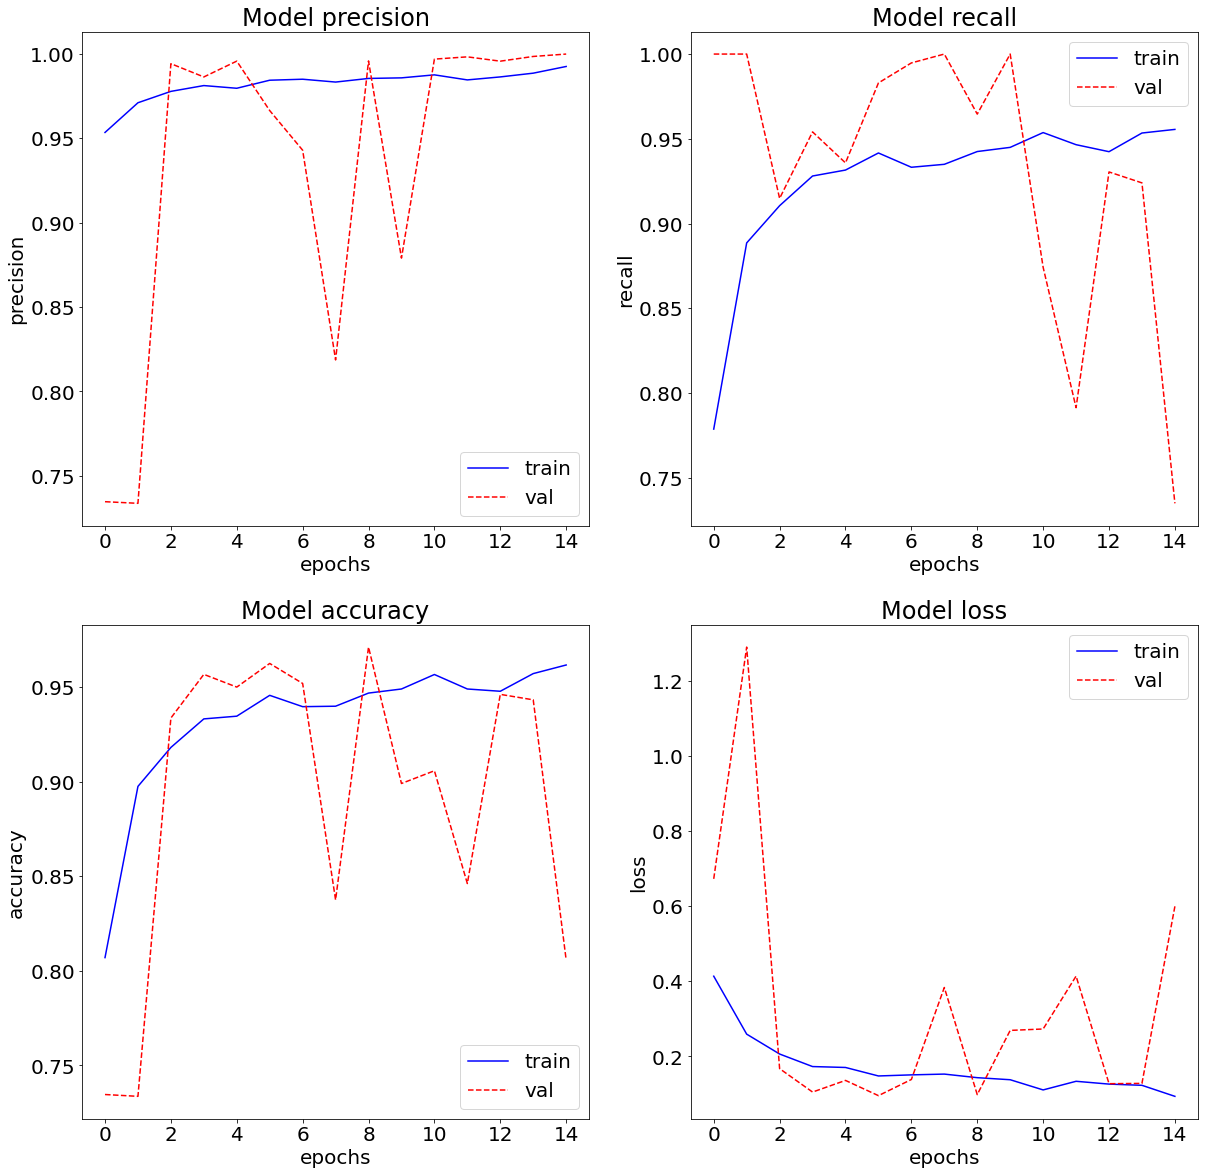

In [451]:
plot_metrics(history)

- 테스트 데이터로 모델 평가

In [452]:
def evaluate_model_print(model, test_ds):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [453]:
evaluate_model_print(model, test_ds)

39/39 [==============================] - 5s 117ms/step - loss: 0.4446 - accuracy: 0.8574 - precision: 0.9440 - recall: 0.8205
Loss: 0.444610595703125,
Accuracy: 0.8573718070983887,
Precision: 0.9439527988433838,
Recall: 0.8205128312110901


-------------------------------------------------------------

### Step 8. 성능 개선 시도
1. 기존 LMS 코드 + Data augmentation
2. Data augmentation + ResNet-18 
3. Batch Normalization 사용하지 않기
4. 기존 LMS 코드 + Dropout 사용하지 않기
5. 기존 LMS 코드 + learing rate schedules

### 1. 기존 LMS 코드 + Data augmentation
- RandomFilp : 반전
- RandomRotation : 회전
- RandomTranslation : 수평, 수직 이동
- RandomZoom도 있지만 확대/축소를 진행하면 오히려 데이터에 방해가 될까봐 하지 않았다.

In [454]:
def create_data_augmentation_layer():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # 약 2.9도 회전
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, fill_mode='constant')
    ])
    return data_augmentation

In [455]:
def prepare_for_training_augmentation(ds, shuffle_buffer_size=1000):
    # 데이터 증강 레이어 생성
    data_augmentation_layer = create_data_augmentation_layer()

    # 데이터 섞기, 반복, 배치 처리, 데이터 읽기 최적화를 적용
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(lambda x, y: (data_augmentation_layer(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

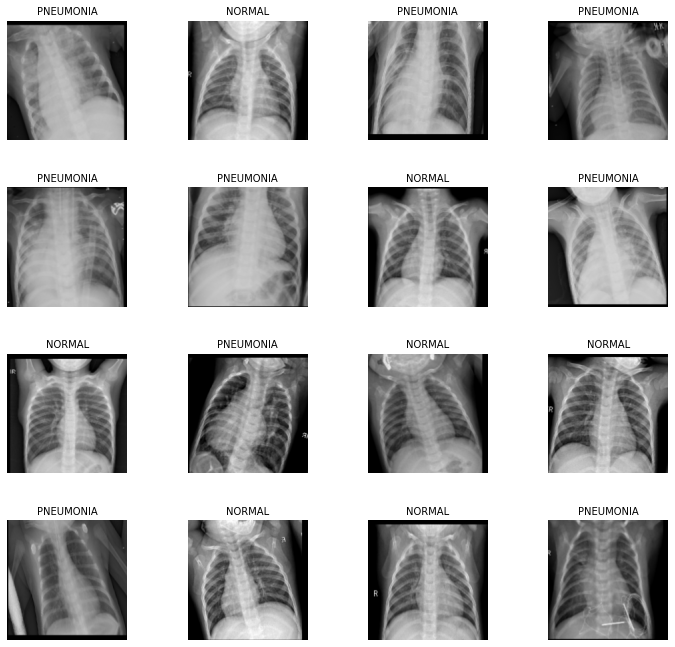

In [456]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 15

# 데이터 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 수 파악하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 변환
train_ds = prepare_for_training_augmentation(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

In [457]:
def conv_block_aug(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [458]:
def dense_block_aug(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [459]:
def build_model_aug():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_aug(32),
        conv_block_aug(64),
        
        conv_block_aug(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_aug(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_aug(512, 0.7),
        dense_block_aug(128, 0.5),
        dense_block_aug(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [460]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [461]:
with tf.device('/GPU:0'):
    model_aug = build_model_aug()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [462]:
model_aug.summary()

Model: "sequential_318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_221 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_311 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_312 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_313 (Sequential)  (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_122 (Dropout)        (None, 11, 11, 128)    

In [463]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 70s 233ms/step - loss: 0.4622 - accuracy: 0.7644 - precision: 0.9392 - recall: 0.7307 - val_loss: 0.6374 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 60s 229ms/step - loss: 0.2806 - accuracy: 0.8865 - precision: 0.9647 - recall: 0.8796 - val_loss: 1.3063 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 60s 231ms/step - loss: 0.2454 - accuracy: 0.8958 - precision: 0.9672 - recall: 0.8904 - val_loss: 0.7248 - val_accuracy: 0.7394 - val_precision: 0.7379 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 62s 239ms/step - loss: 0.2379 - accuracy: 0.9030 - precision: 0.9681 - recall: 0.8993 - val_loss: 0.1611 - val_accuracy: 0.9404 - val_precision: 0.9848 - val_recall: 0.9332
Epoch 5/15
261/261 [==============================] - 64s 245ms/step - loss: 0.1997 - accura

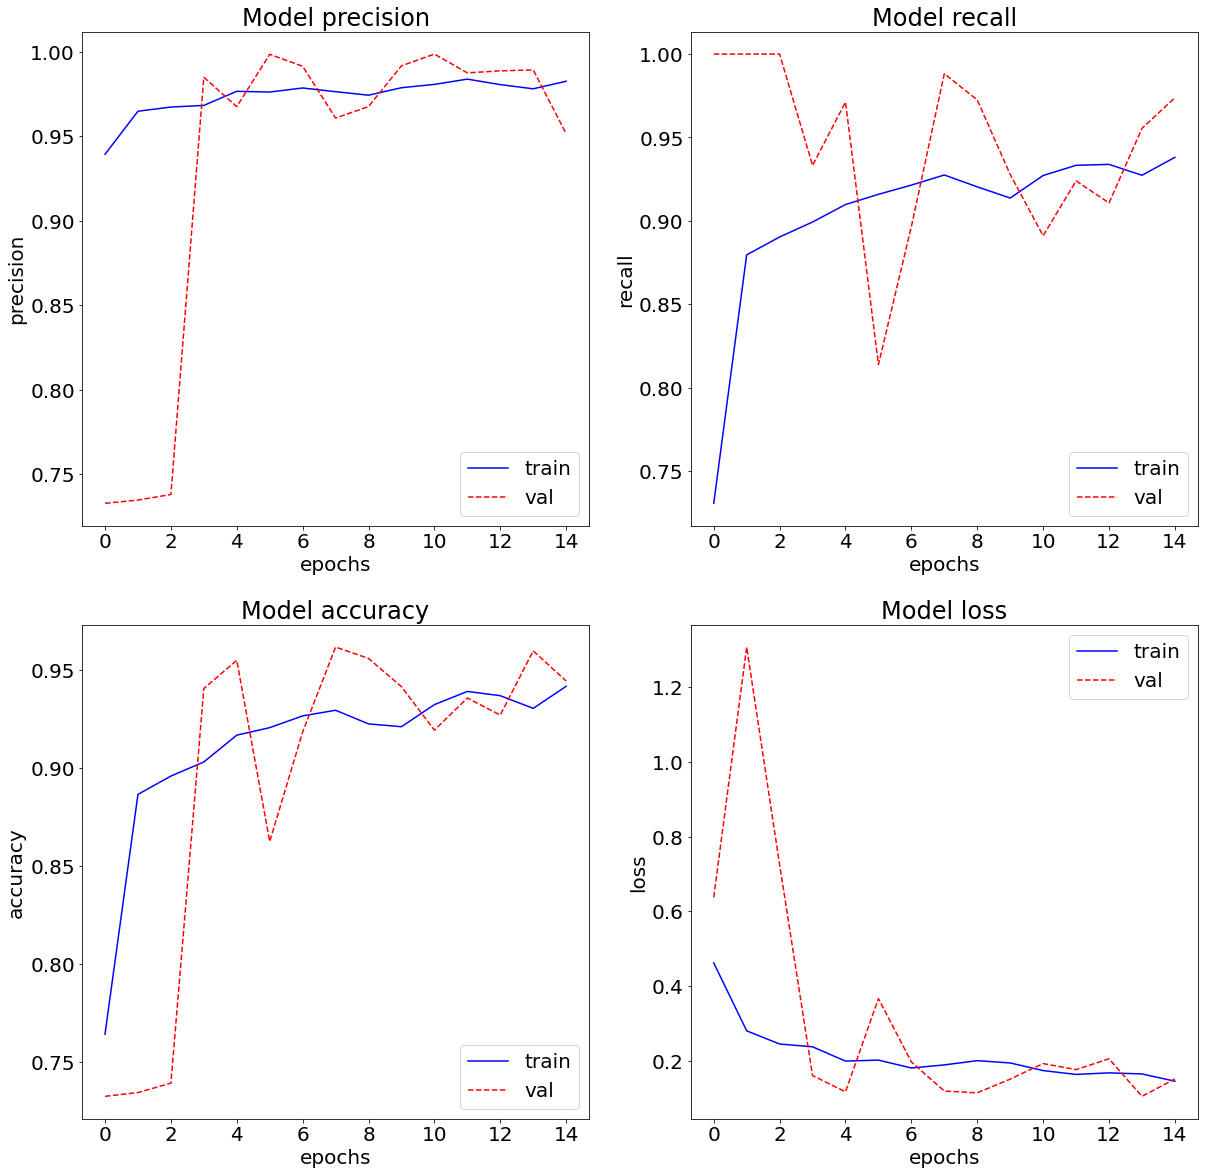

In [464]:
plot_metrics(history_aug)

In [465]:
evaluate_model_print(model_aug, test_ds)

39/39 [==============================] - 5s 119ms/step - loss: 0.6595 - accuracy: 0.7708 - precision: 0.7389 - recall: 0.9795
Loss: 0.6594775319099426,
Accuracy: 0.7708333134651184,
Precision: 0.7388781309127808,
Recall: 0.9794871807098389


### 2. Data augmentation + ResNet-18 구현

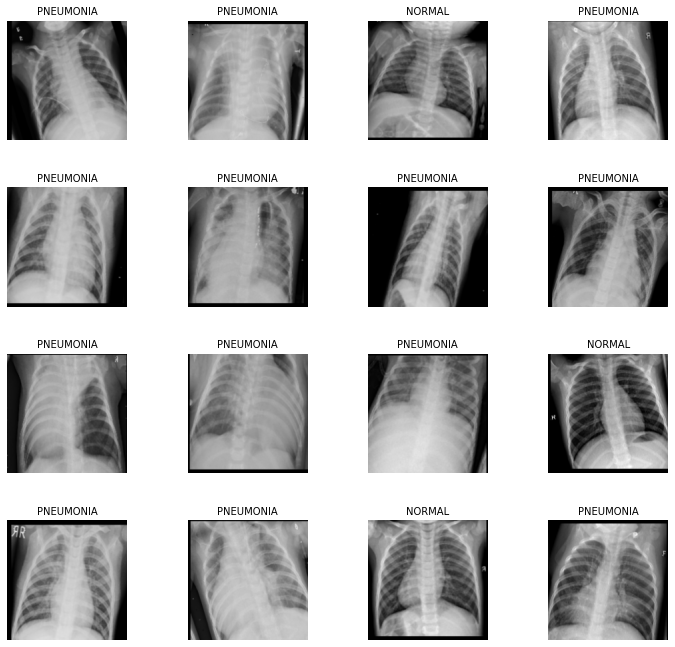

In [506]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 15

# 데이터 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 수 파악하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 변환
train_ds = prepare_for_training_augmentation(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

In [507]:
def residual_block(filters, strides=1):
    shortcut = tf.keras.Sequential()
    if strides > 1:
        shortcut.add(tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='valid'))
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 3, activation='relu', strides=strides, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters, 3, activation='relu', strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
    ])

In [508]:
def build_resnet_18():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 7, 2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        
        residual_block(64),
        residual_block(64),
        
        residual_block(128, strides=2),
        residual_block(128),
        
        residual_block(256, strides=2),
        residual_block(256),
        
        residual_block(512, strides=2),
        residual_block(512),
        
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='softmax')
        
    ])
    
    return model

In [509]:
# weight balancing
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

In [510]:
with tf.device('/GPU:0'):
    model_Res_Net_aug = build_resnet_18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model_Res_Net_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [511]:
model_Res_Net_aug.summary()

Model: "sequential_378"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 90, 90, 64)        9472      
_________________________________________________________________
batch_normalization_346 (Bat (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 45, 45, 64)        0         
_________________________________________________________________
sequential_363 (Sequential)  (None, 45, 45, 64)        74368     
_________________________________________________________________
sequential_365 (Sequential)  (None, 45, 45, 64)        74368     
_________________________________________________________________
sequential_367 (Sequential)  (None, 23, 23, 128)       222464    
_________________________________________________________________
sequential_369 (Sequential)  (None, 23, 23, 128)    

In [512]:
with tf.device('/GPU:0'):
    history_Res_Net_aug = model_Res_Net_aug.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping],
    )

Epoch 1/15
261/261 [==============================] - 70s 231ms/step - loss: 0.3980 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 4.4004 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 59s 226ms/step - loss: 0.2583 - accuracy: 0.7452 - precision: 0.7452 - recall: 1.0000 - val_loss: 1.5348 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 58s 224ms/step - loss: 0.2114 - accuracy: 0.7457 - precision: 0.7457 - recall: 1.0000 - val_loss: 0.1613 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 60s 231ms/step - loss: 0.1961 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 1.5972 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 5/15
261/261 [==============================] - 60s 231ms/step - loss: 0.1830 - accura

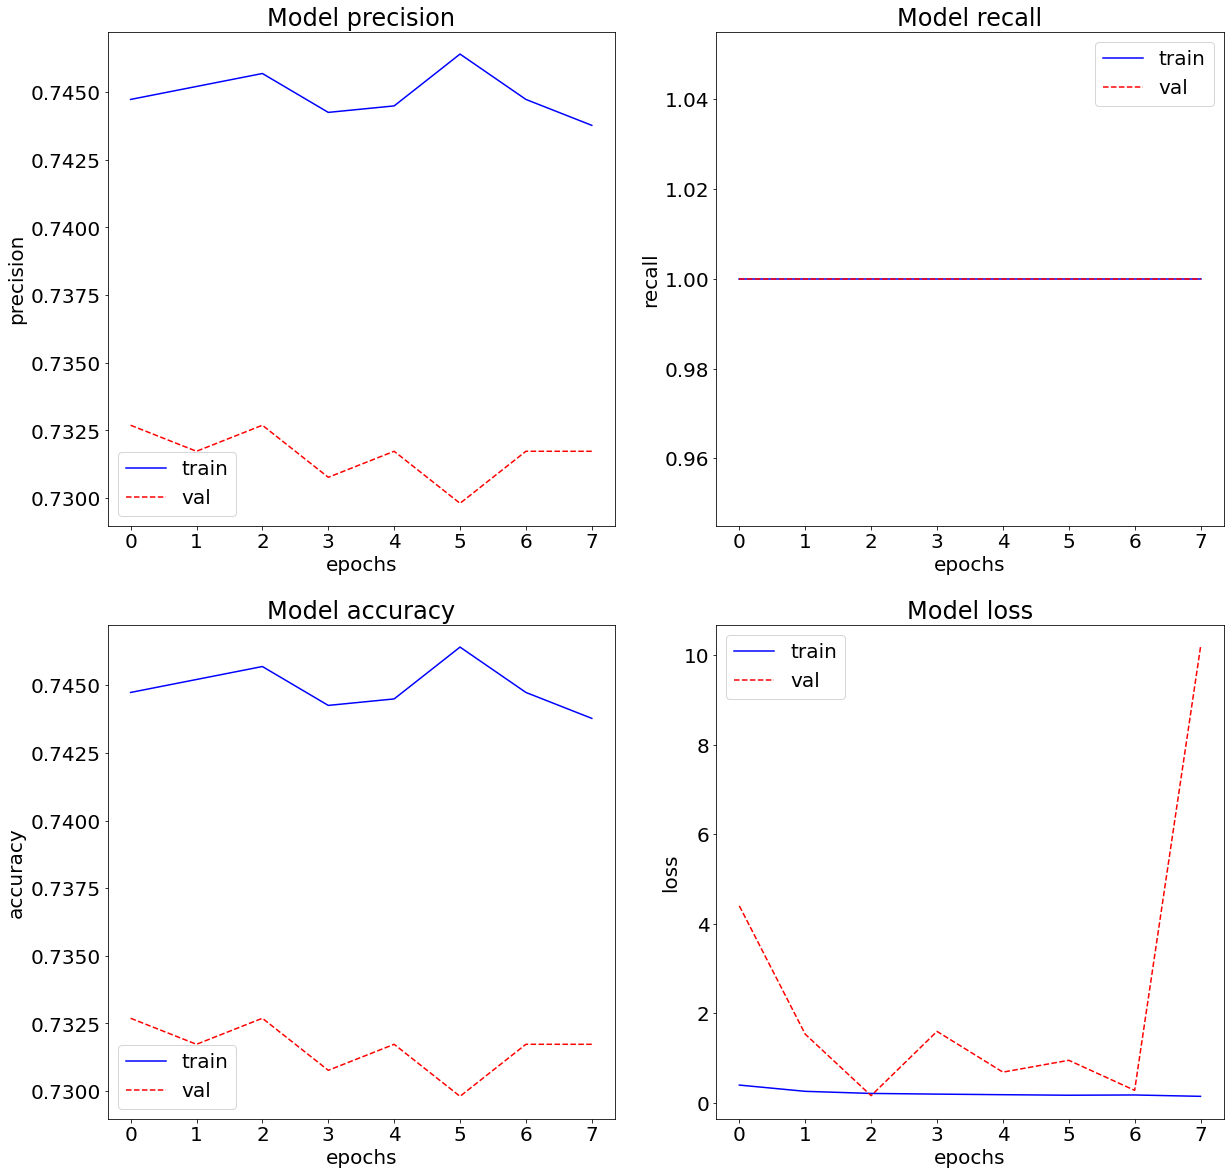

In [513]:
plot_metrics(history_Res_Net_aug)

In [514]:
evaluate_model_print(model_Res_Net_aug, test_ds)

39/39 [==============================] - 4s 106ms/step - loss: 0.8063 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.8062576651573181,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 2. Batch Normalization 사용하지 않기
- 기본 LMS 코드에서 Batch Normalization을 사용하지 않고 학습

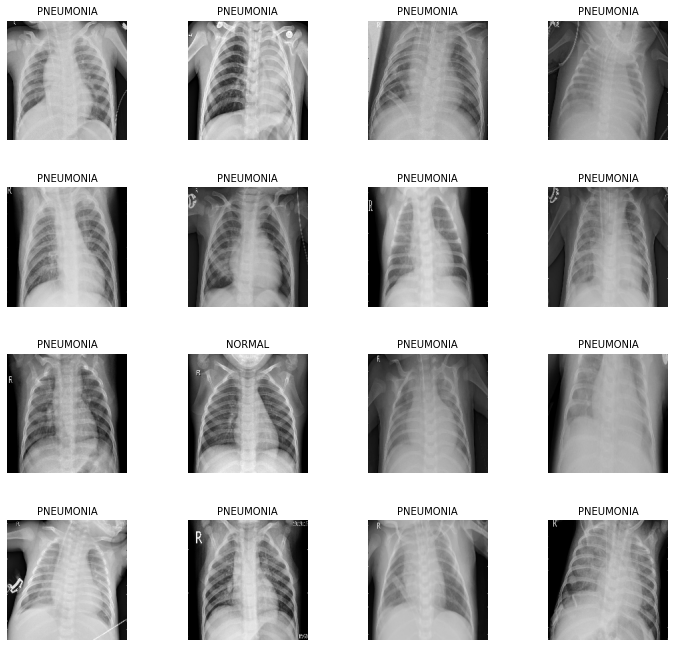

In [475]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

# 데이터 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 수 파악하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 변환
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

In [476]:
def conv_block_nobatch(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [477]:
def dense_block_nobatch(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [478]:
def build_model_nobatch():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_nobatch(32),
        conv_block_nobatch(64),
        
        conv_block_nobatch(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_nobatch(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_nobatch(512, 0.7),
        dense_block_nobatch(128, 0.5),
        dense_block_nobatch(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [479]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [480]:
with tf.device('/GPU:0'):
    model_nobatch = build_model_nobatch()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    model_nobatch.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [481]:
model_nobatch.summary()

Model: "sequential_344"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_243 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_337 (Sequential)  (None, 45, 45, 32)        2032      
_________________________________________________________________
sequential_338 (Sequential)  (None, 22, 22, 64)        7136      
_________________________________________________________________
sequential_339 (Sequential)  (None, 11, 11, 128)       26560     
_________________________________________________________________
dropout_127 (Dropout)        (None, 11, 11, 128)    

In [482]:
with tf.device('/GPU:0'):
    history_nobatch = model_nobatch.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping],
    )

Epoch 1/20
261/261 [==============================] - 61s 198ms/step - loss: 0.6942 - accuracy: 0.5007 - precision: 0.7394 - recall: 0.5066 - val_loss: 0.6884 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 193ms/step - loss: 0.6931 - accuracy: 0.5776 - precision: 0.7471 - recall: 0.6533 - val_loss: 0.6987 - val_accuracy: 0.2606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
261/261 [==============================] - 51s 194ms/step - loss: 0.6938 - accuracy: 0.5103 - precision: 0.7482 - recall: 0.5129 - val_loss: 0.7232 - val_accuracy: 0.2625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
261/261 [==============================] - 51s 198ms/step - loss: 0.6937 - accuracy: 0.4193 - precision: 0.7359 - recall: 0.3412 - val_loss: 0.6966 - val_accuracy: 0.2606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
261/261 [==============================] - 51s 196ms/step

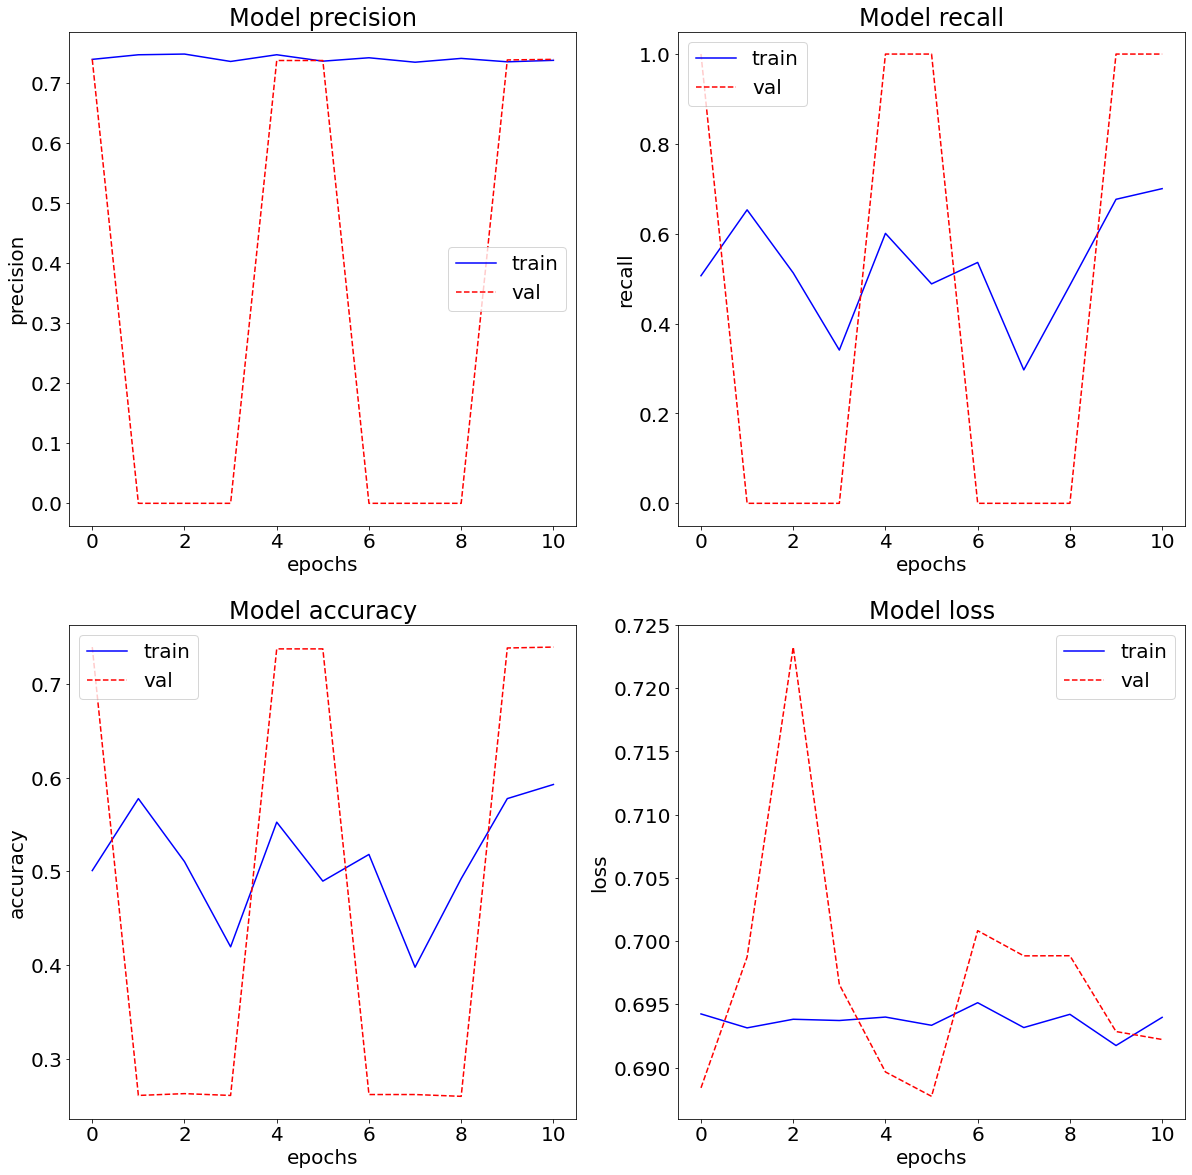

In [483]:
plot_metrics(history_nobatch)

In [484]:
evaluate_model_print(model_nobatch, test_ds)

39/39 [==============================] - 5s 116ms/step - loss: 0.6903 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6903245449066162,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 3. Dropout 사용하지 않기
- 기본 LMS 코드에서 Dropout을 사용하지 않고 모델 학습

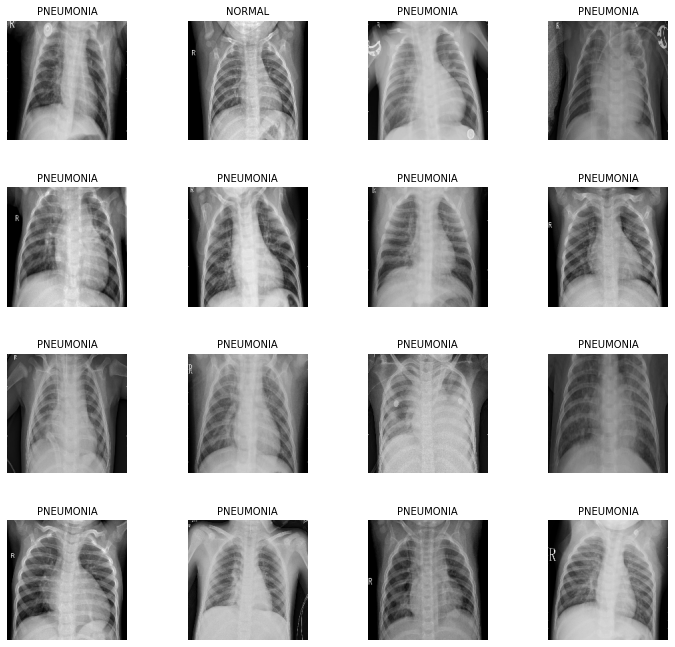

In [485]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 15

# 데이터 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 수 파악하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 변환
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

In [486]:
def conv_block_nodrop(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [487]:
def dense_block_nodrop(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [488]:
def build_model_nodrop():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_nodrop(32),
        conv_block_nodrop(64),
        
        conv_block_nodrop(128),
        # tf.keras.layers.Dropout(0.2),
        
        conv_block_nodrop(256),
        # tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_nodrop(512, 0.7),
        dense_block_nodrop(128, 0.5),
        dense_block_nodrop(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [489]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [490]:
with tf.device('/GPU:0'):
    model_nodrop = build_model_nodrop()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_nodrop.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [491]:
model_nodrop.summary()

Model: "sequential_352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_245 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_345 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_346 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_347 (Sequential)  (None, 11, 11, 128)       27072     
_________________________________________________________________
sequential_348 (Sequential)  (None, 5, 5, 256)      

In [492]:
with tf.device('/GPU:0'):
    history_nodrop = model_nodrop.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping],
    )

Epoch 1/15
261/261 [==============================] - 62s 203ms/step - loss: 0.3166 - accuracy: 0.8487 - precision: 0.9700 - recall: 0.8220 - val_loss: 0.6823 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 51s 195ms/step - loss: 0.2213 - accuracy: 0.9174 - precision: 0.9765 - recall: 0.9108 - val_loss: 1.1033 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 51s 195ms/step - loss: 0.1784 - accuracy: 0.9368 - precision: 0.9817 - recall: 0.9324 - val_loss: 0.4178 - val_accuracy: 0.8000 - val_precision: 0.7858 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 52s 199ms/step - loss: 0.1484 - accuracy: 0.9452 - precision: 0.9829 - recall: 0.9426 - val_loss: 0.1006 - val_accuracy: 0.9625 - val_precision: 0.9827 - val_recall: 0.9660
Epoch 5/15
261/261 [==============================] - 52s 201ms/step - loss: 0.1478 - accura

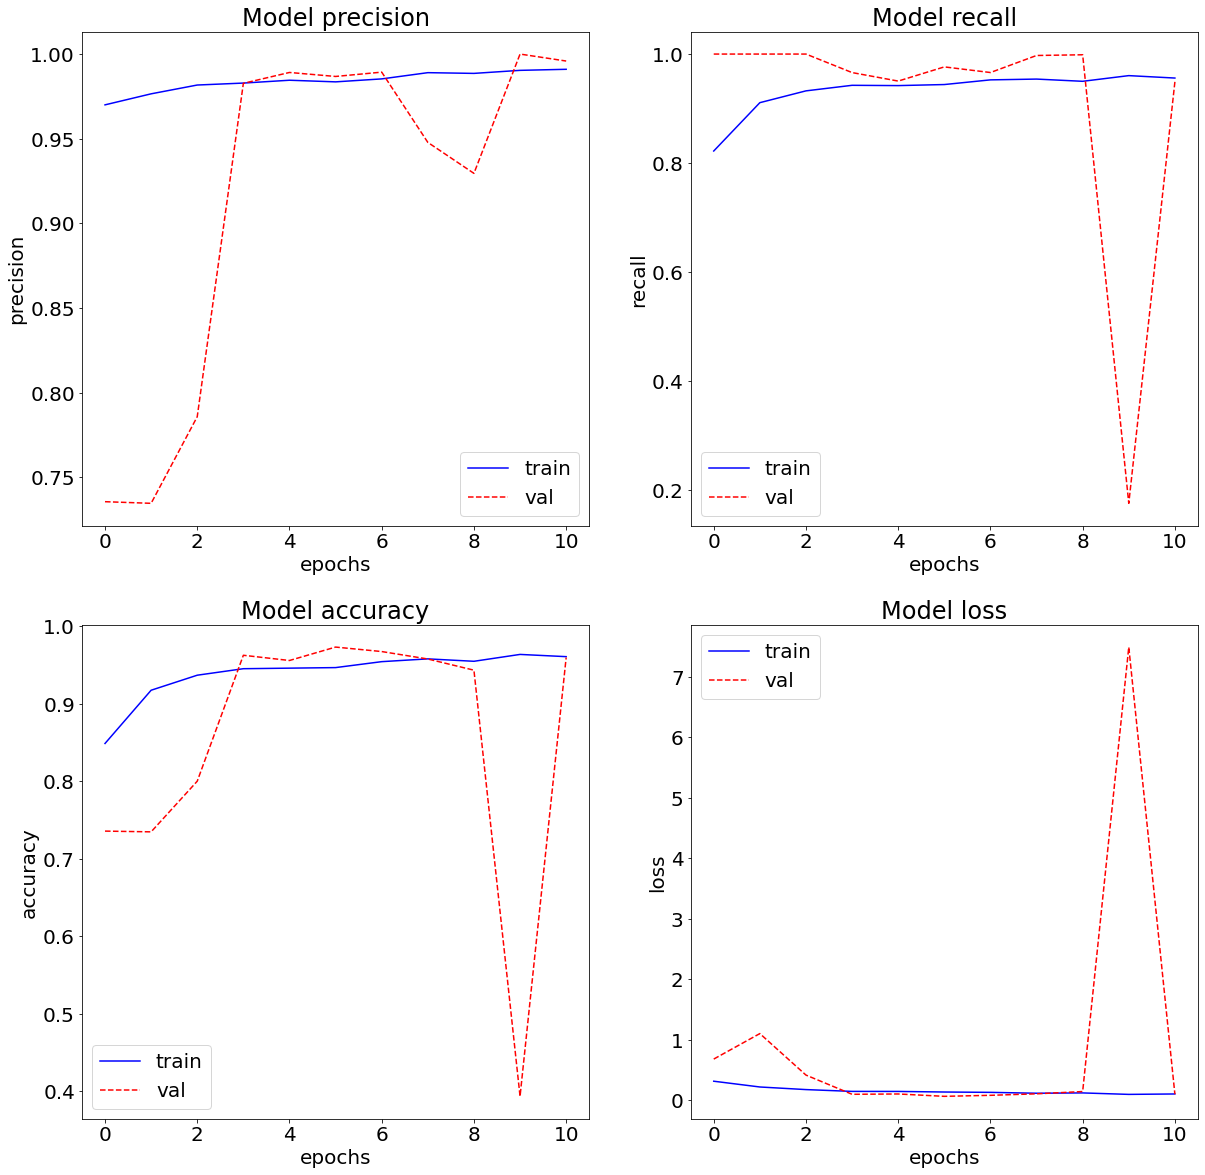

In [493]:
plot_metrics(history_nodrop)

In [494]:
evaluate_model_print(model_nodrop, test_ds)

39/39 [==============================] - 5s 119ms/step - loss: 0.6840 - accuracy: 0.7756 - precision: 0.7413 - recall: 0.9846
Loss: 0.6839895248413086,
Accuracy: 0.7756410241127014,
Precision: 0.7413127422332764,
Recall: 0.9846153855323792


### 기존 LMS 코드 + learing rate schedules

In [495]:
# Learning rate 스케줄러 생성
initial_learning_rate = 0.001  # 초기 learning rate 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)

# Optimizer를 생성하고 learning rate 스케줄러 적용
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [496]:
with tf.device('/GPU:0'):
    model_lr = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model_lr.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [497]:
with tf.device('/GPU:0'):
    history_lr = model_lr.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        # callbacks=[early_stopping],
    )

Epoch 1/15
261/261 [==============================] - 60s 197ms/step - loss: 0.3886 - accuracy: 0.8113 - precision: 0.9520 - recall: 0.7858 - val_loss: 0.6649 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 50s 193ms/step - loss: 0.2433 - accuracy: 0.9085 - precision: 0.9710 - recall: 0.9041 - val_loss: 1.2478 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 50s 194ms/step - loss: 0.2121 - accuracy: 0.9152 - precision: 0.9748 - recall: 0.9095 - val_loss: 0.2489 - val_accuracy: 0.9144 - val_precision: 0.9843 - val_recall: 0.8982
Epoch 4/15
261/261 [==============================] - 51s 197ms/step - loss: 0.1526 - accuracy: 0.9389 - precision: 0.9834 - recall: 0.9337 - val_loss: 1.3558 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/15
261/261 [==============================] - 53s 202ms/step - loss: 0.1593 - accura

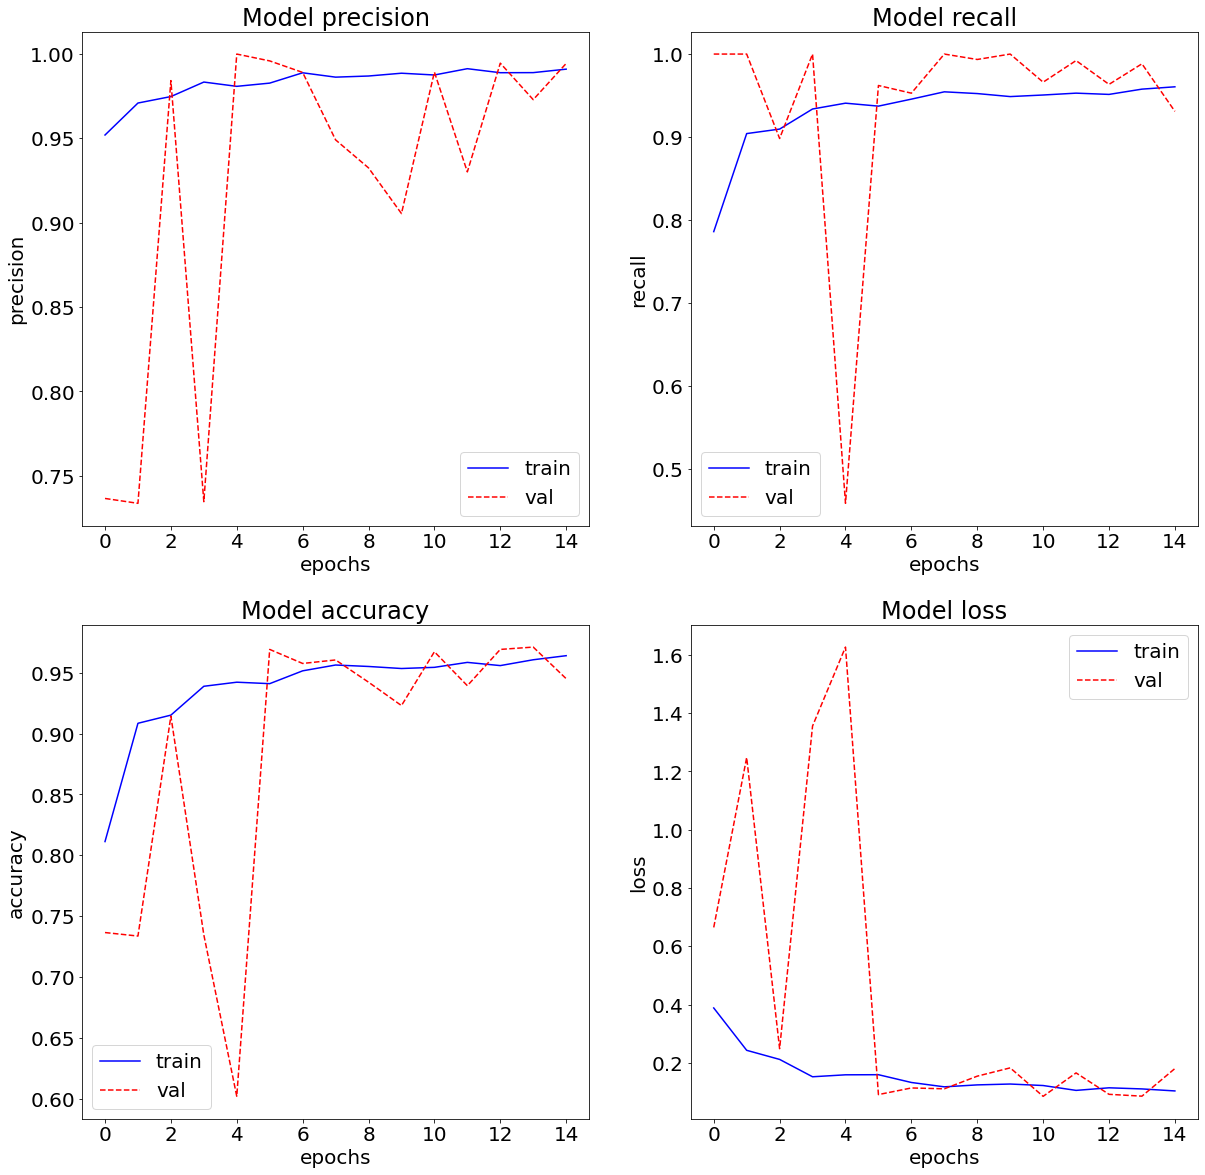

In [498]:
plot_metrics(history_lr)

In [499]:
evaluate_model_print(model_lr, test_ds)

39/39 [==============================] - 5s 116ms/step - loss: 0.4357 - accuracy: 0.8734 - precision: 0.8591 - recall: 0.9538
Loss: 0.4356946647167206,
Accuracy: 0.8733974099159241,
Precision: 0.8591223955154419,
Recall: 0.9538461565971375


### Step 9. 결론

### 기존 LMS 코드

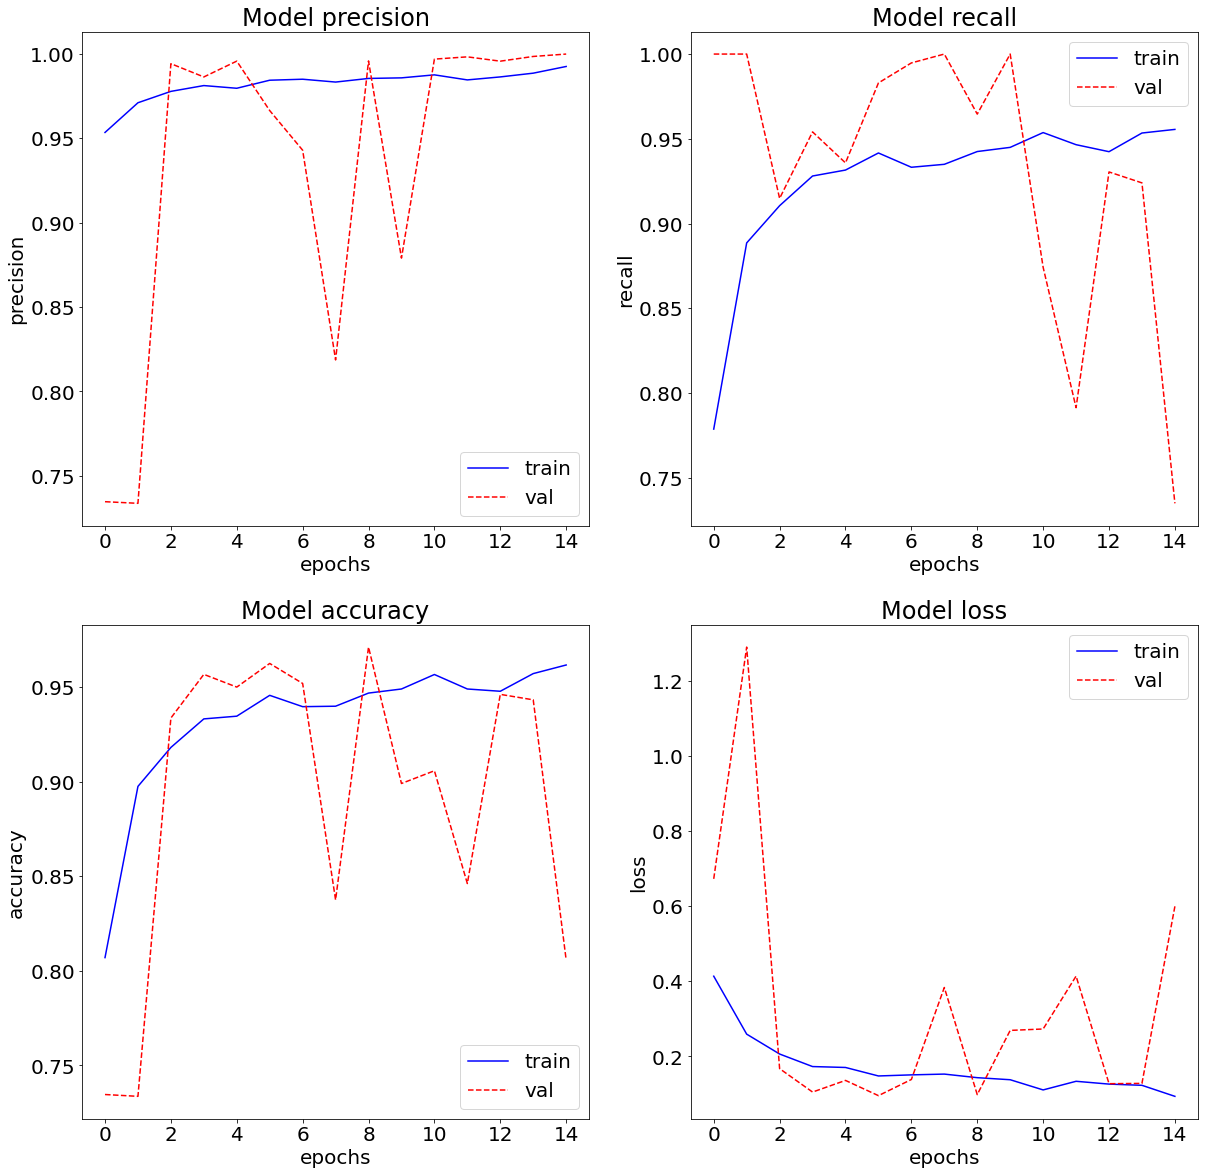

In [500]:
plot_metrics(history)

### 기존 LMS 코드 + Data augmentation

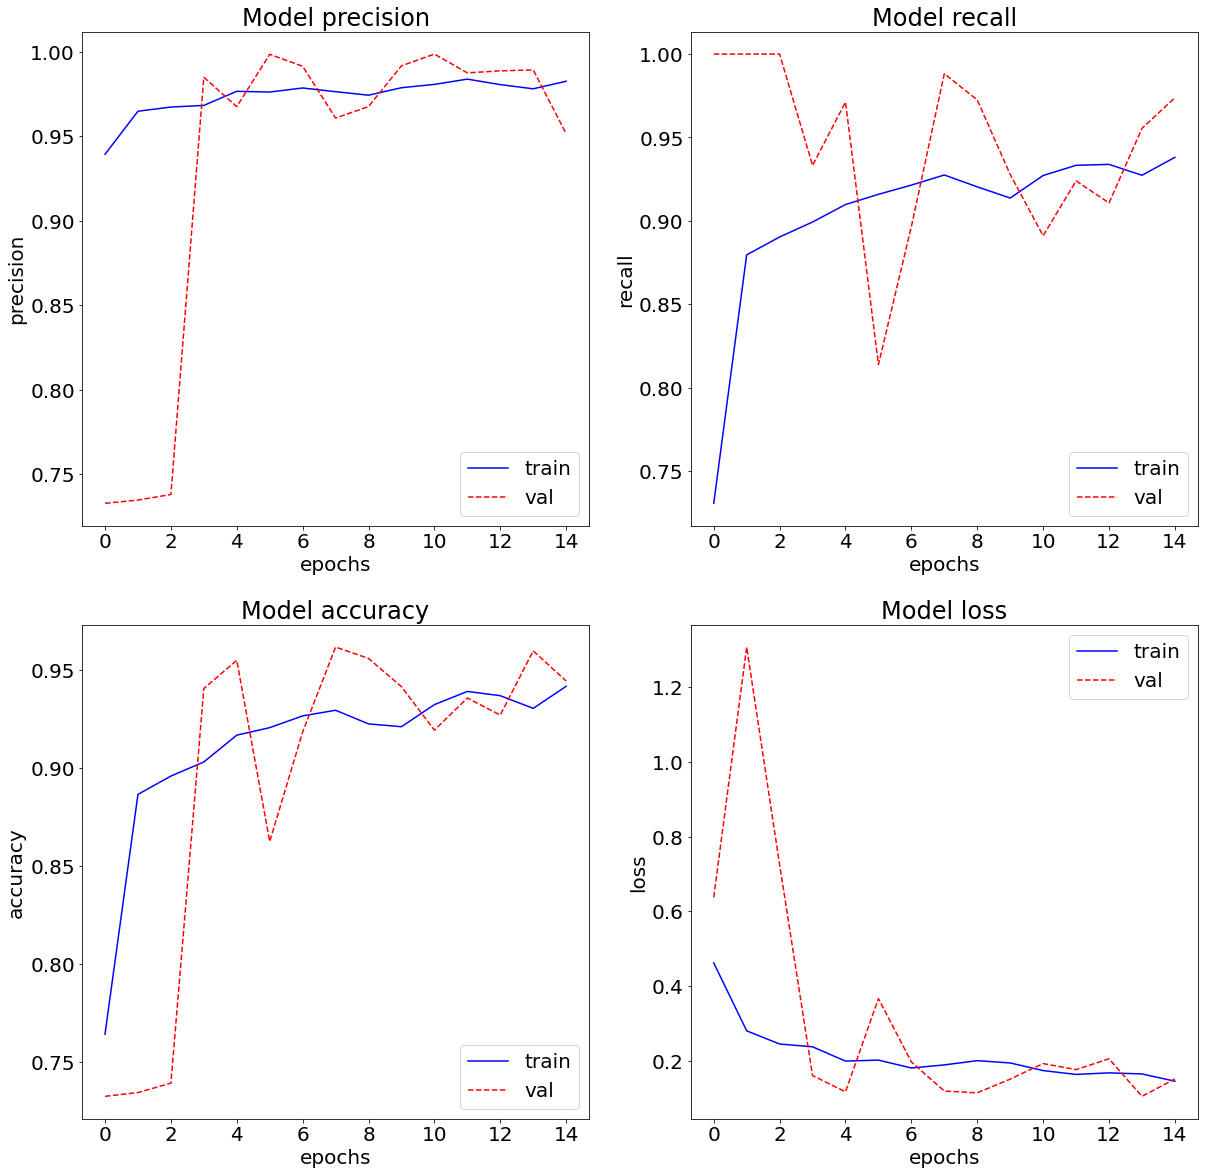

In [501]:
plot_metrics(history_aug)

### ResNet-18 + Data augmentation

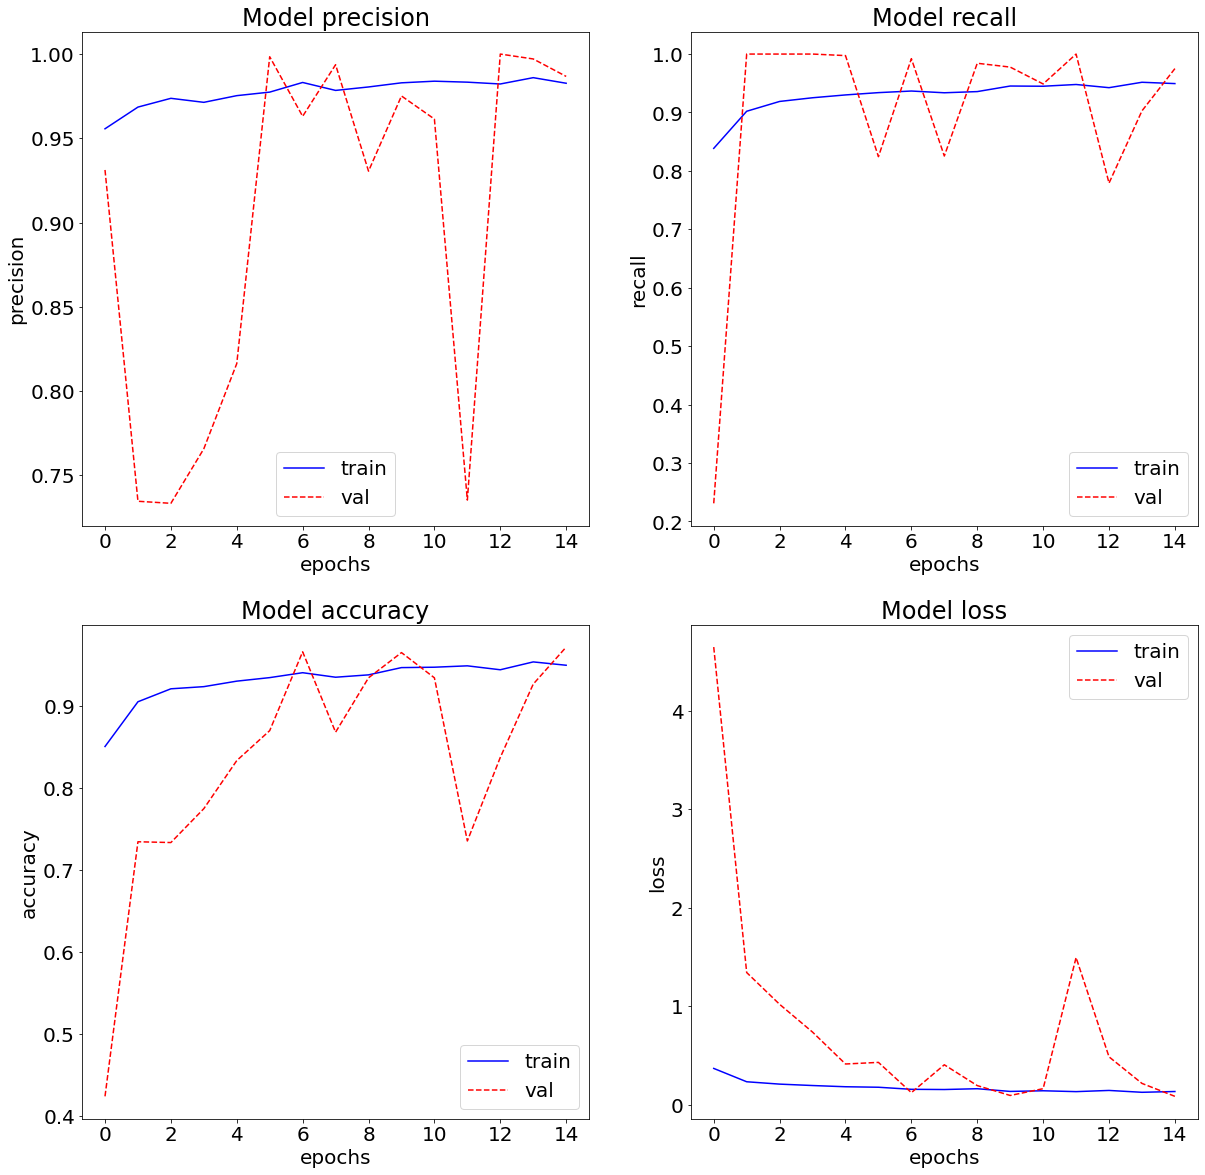

In [502]:
plot_metrics(history_Res_Net_aug)

### 기존 LMS 코드 - BatchNormalization

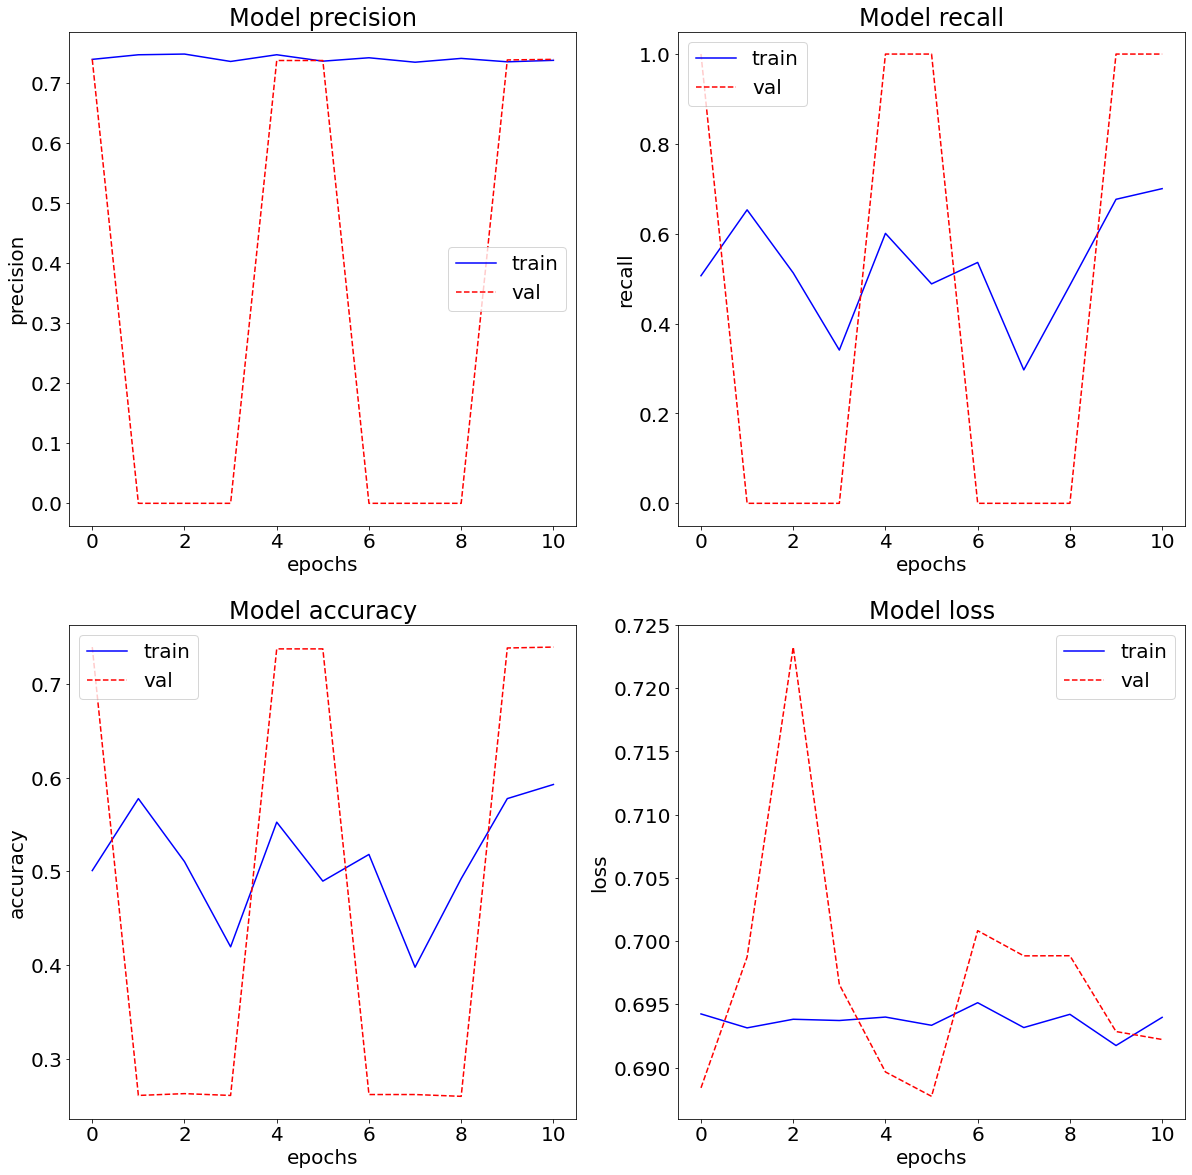

In [503]:
plot_metrics(history_nobatch)

### 기존 LMS 코드 - Dropout

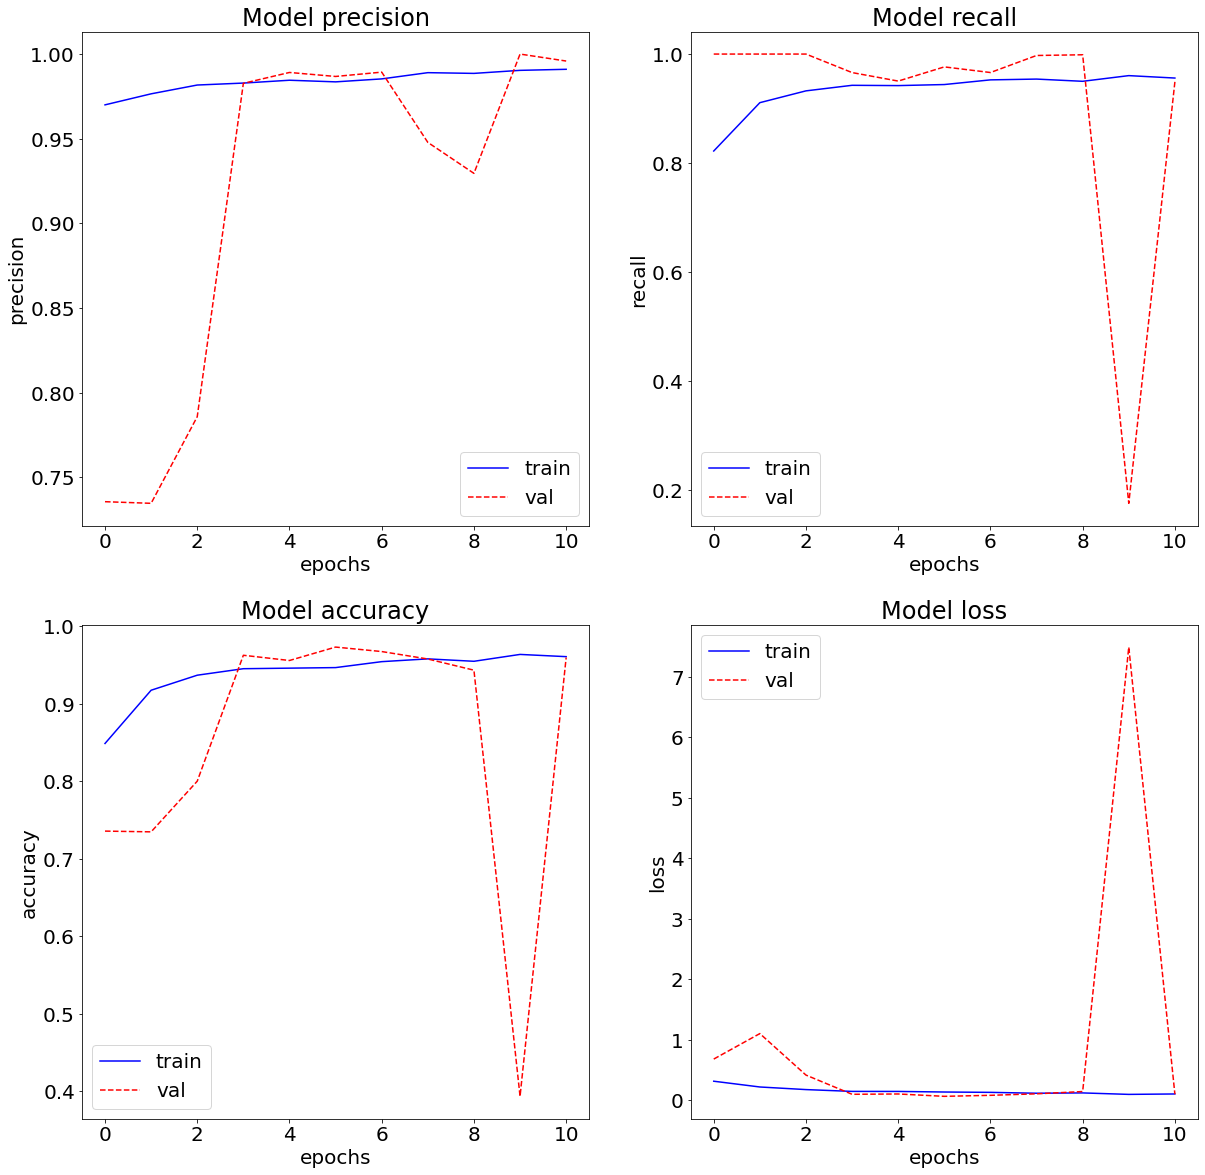

In [504]:
plot_metrics(history_nodrop)

### 기존 LMS 코드 + learing rate schedules

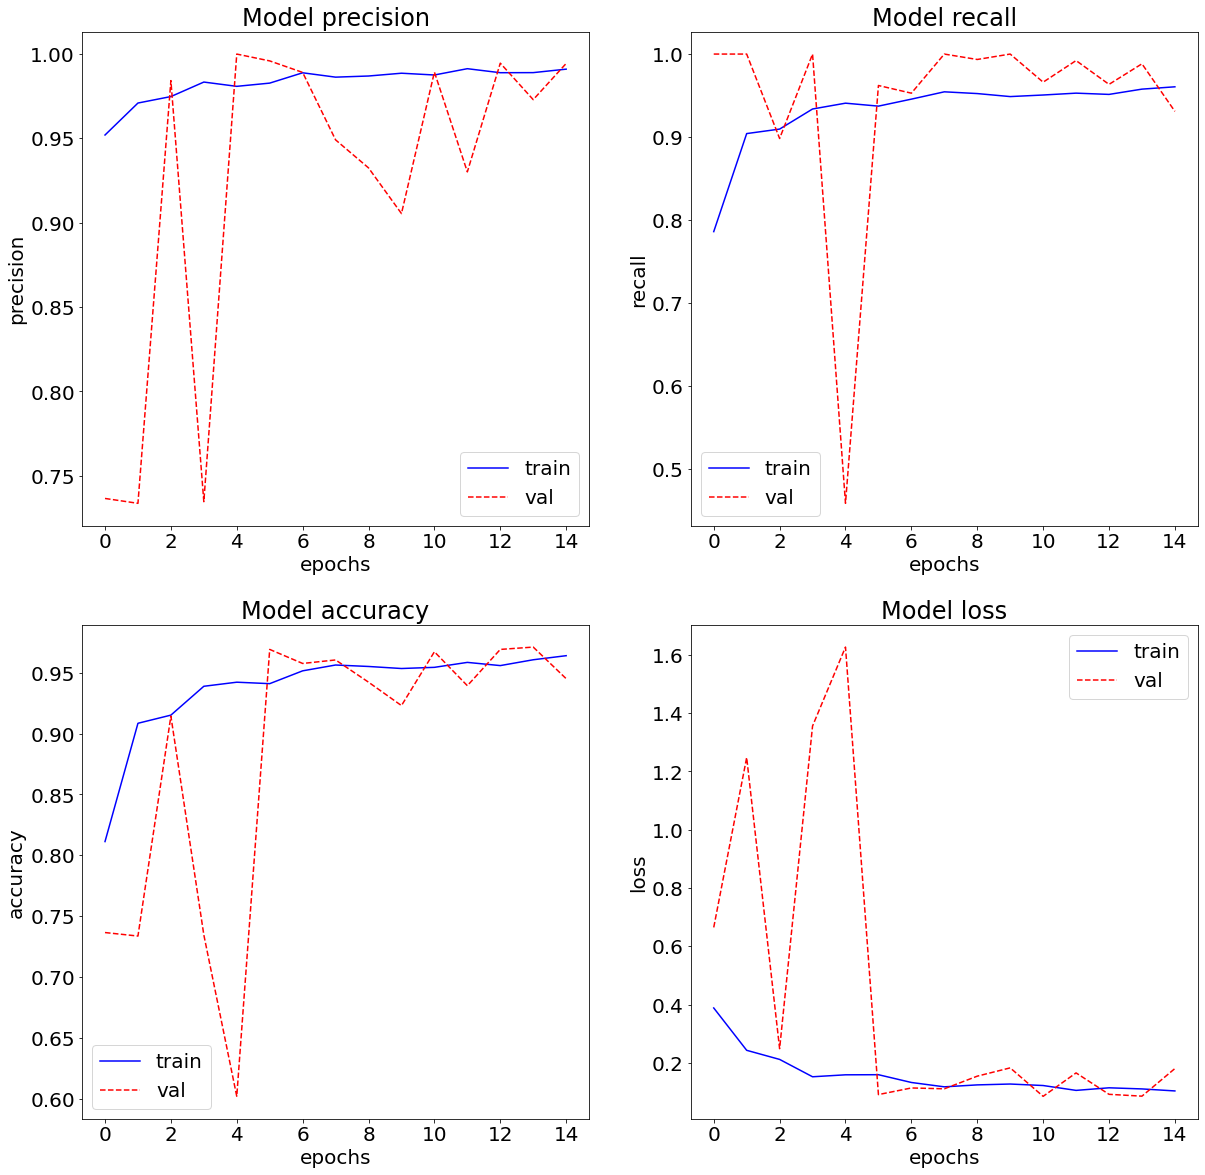

In [505]:
plot_metrics(history_lr)

|Evaluation|LMS 코드 CNN|LMS 코드 + Data augmentation|ResNet-18 + Data augmentation|LMS 코드 - BatchNormalization|LMS 코드 - Dropout|LMS 코드 + lr schedules|
|:------:|:---:|:---:|:---:|:---:|:---:|:---:|
|Loss|0.44|0.66|0.58|0.69|0.68|0.44|
|Accuracy|0.86|0.77|0.82|0.63|0.78|0.87|
|Precision|0.94|0.74|0.79|0.63|0.74|0.86|
|Recall|0.82|0.98|0.98|1.0|0.98|0.95|

- ResNet-18 + Data augmentation 모델의 활성화 함수<br/>
 **sigmoid**
    - Loss: 0.5771560668945312,
    - Accuracy: 0.8221153616905212,
    - Precision: 0.7852760553359985,
    - Recall: 0.9846153855323792
    
 **softmax**
    - Loss: 0.8062576651573181,
    - Accuracy: 0.625,
    - Precision: 0.625,
    - Recall: 1.0

- 같은 분류 활성화 함수이지만 
- sigmoid는 이진 분류에 적합하며 출력값은 0과 1사이로 스켕일링하고,
- softmax는 다중 클래스 분류이지만 레이블이 2개인 경우에도 사용가능하여
- 두 활성화 함수를 사용해보았다.
- 확실히 이진 분류에 적합하게 사용되는 sigmoid 활성화 함수가 더 좋은 성능을 보인다.
<br/><br/>
- **기존 LMS 코드 CNN**은 accuracy가 86%, precision이 94%로 성능이 높게 나왔다.
- **기존 LMS 코드 + Data augmentation**은 accuracy가 77%, precision이 74%로 augmentation으로 데이터를 변환을 해서 오히려 방해를 받아 성능이 떨어진것같다.
- **ResNet-18 + Data augmentation**은 accuracy가 82%, precision은 79%로 기존 LMS 코드에 augmentation을 한 결과보다 좋은 결과를 보이지만 이 또한 데이터 변환으로 인해 방해를 받아 성능이 떨어진 것 같다.
- **기존 LMS 코드 - BatchNormalization**은 accuracy가 63%, precision은 63%로 epoch 11에서 early stopping이 되었고, loss와 accuracy가 11 epoch 동안 진전을 보이지 않았다.
- **기존 LMS 코드 - Dropout**은 accuracy가 78%, precision은 74%로 Dropout을 하지않아 과적합이나 일반화 문제에 빠졌을 가능성이 있다. 
- **기존 LMS 코드 + learning rate schedules**은 accuracy가 87%, precision은 86%로 이전 모델들 중에 가장 성능이 좋다. lr을 동적으로 계속 조절하여 안정적으로 수렴하도록 도와주고 과적합 방지와 일반화 능력이 향상되는 효과 때문에 성능이 좋게 나온걸로 보인다.

### Step 10. 회고

- 어떤 방법 모델이 좋을지 고민을 하였지만, 새로운 아이디어가 떠오르지 않아 노드에서 말했던 방법대로 batchnormalization이나 dropout, data augmentation을 사용하여 모델 학습을 진행해보았다.
- 좀 더 색다르게 방법을 생각해 낼 수 있는 정보들을 공부할 필요성을 느꼈다.
- early stopping을 사용하여 처음에는 patience=3으로 지정했지만, loss의 감소폭이 줄어들거나 하는 경우 early stop이 너무 자주 일어나서 patience=5로 바꾸어 실험을 진행했다.
- data augmentation을 train 데이터에만 사용하였다. 
- 이는 test 데이터에서는 모델의 일반화 능력을 평가, 
- test 데이터에도 적용하면 모델 평가의 신뢰성이 떨어질 수도 있는 현상이 발생할 것 같아 trian 데이터에만 data augmentation을 사용하였다.
- 그리고 더 다양한 data augmentation 기법을 사용하여 적용하는 방법을 알아봐야 겠다.